SVM Support Vector Machine<br>


It's one of the algorithms to find the decision boundary, just like the K-means that we did last time.<br>
It can be used for classification or regression, and if it's a difference from the previous kmeans,<br>
The kmeans algorithm is to find the cluster center, find the nearest Euclidean distance, and create a boundary<br>
For the support vector machine, find the line that draws the optimal decision boundary.<br>
A plane based on the data that is farthest from the data is called a hyperplane.<br>
![title](./photo/Linear_SVM.png)<br>
And an important concept that emerges in the support vector machine is margin
This means the maximum amount of space that a given data can move without causing errors.<br>
If you look at the picture above, the red line is more stable than the two black lines.<br>
the margin is as follows:<br>

![title](./photo/Margin_gradient.png)<br>
this form make easier when taking garidnets<br>


![title](./photo/Linear_SVM2.png)<br>

They are the blue and black lines in the above figure. Without allowing any misclassifications in the hard margin SVM<br>
we want to maximize the distance between the two hyperplanes(bule lines).<br> 
To find this distance, we can use the formula for the distance of a point from a plane.<br> 
So the distance of the blue points and the red point from the black line would respectively be:<br>
![title](./photo/primal.png)<br>

This optimization is called the primal problem and is guaranteed to have a global minimum.<br> 


We can solve this by introducing Lagrange multipliers $(\lambda_i)$ and converting it to the dual problem<br>
![title](./photo/dual_hard.png)<br>


But in case all the data can be completely separated won't be very common.<br>
Misclassifying situations may exist.<br>
So, we usally use soft margin to allow misclassification errors when a given sample cannot be separated perfectly linearly.<br>
![title](./photo/soft_svm.png)<br>

Here, C is the parameter set by user,<br> 
The soft margin SVM follows a somewhat similar optimization procedure with a couple of differences.<br> 
First, in this scenario, we allow misclassifications to happen.<br> 
So we’ll need to minimize the misclassification error,<br> 
which means that we’ll have to deal with one more constraint.<br> 
Second, to minimize the error, we should define a loss function.<br> 
A common loss function used for soft margin is the hinge loss.<br>


and if the C value is set to be large, <br>
the misclassification error will be reduced, but the margin will also be reduced.<br>
Setting the C value to a smaller value increases the margin, but also increases the misclassification error.<br>
finally, dual problems of soft margin svm follwing equation:<br>
![title](./photo/dual_soft.png)<br>


We can compare hard margin svm and soft margin svm like this.<br>
![title](./photo/compare_svm.png)<br>



So linear data can be classified like this, but what about nonlinear data?<br>
This is done by performing linear classification by mapping low-dimensional data to high-dimensional via kernel functions.<br>
![title](./photo/Non_linear_svm.png)<br>
By generating and classifying one more dimension through the kernel function $\phi$, <br>
we can finally obtain nonlinear classification data, such as the figure on the left.<br>

However, if the SVM can classify only binary data, it is useless for Multicalss such as iris.<br>
Eventually, it should be possible to classify multi-class by applying svm, and the algorithms that appear are one vs rest, one vs one algorithm.<br>


As soft margin sholuld solve with quadratic programming, I'll use cvxopt and see the result

In [25]:
# data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt
import cvxopt.solvers
from sklearn.model_selection import train_test_split
from sklearn.metrics import *


In [26]:
iris = pd.read_csv('D:\\OneDrive\\Documents\\SJTU 과제\\기계학습(머신러닝)\\Machine_Learning\\iris.data')
X= iris.iloc[:,:4] #학습할데이터
y = iris.iloc[:,-1] #타겟
y

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
def feature_normalize(X):

  #Note here we need mean of indivdual column here, hence axis = 0
  mu = np.mean(X, axis = 0)  
  # Notice the parameter ddof (Delta Degrees of Freedom)  value is 1
  sigma = np.std(X, axis= 0, ddof = 1)  # Standard deviation The reason for specifying the standard deviation ddof is that numpy's std default is 0
  X_norm = (X - mu)/sigma
  return X_norm #, mu, sigma

In [29]:
X_train = feature_normalize(X_train)
X_test = feature_normalize(X_test)

In [30]:
print(X_train[:2])
print(X_test[:2])

    sepal_length  sepal_width  petal_length  petal_width
22     -1.467783     1.198632     -1.556011    -1.307122
15     -0.132515     2.979881     -1.270679    -1.041267
    sepal_length  sepal_width  petal_length  petal_width
73      0.142007    -0.623850      0.443526    -0.078102
18     -0.331351     1.975526     -1.185754    -1.187966


In [31]:
#fitting datatype
X_train= X_train.to_numpy()
X_test = X_test.to_numpy()

Now let's try to implement hard margin svm first with gradient method

In [32]:
"""
apply Lagrange multiplier with kkt and implement hard margin 
L(x,aplha)=F(x)+apha*h(x)
update w*xi +b >1 for two cases
yi=1  and yi=-1
for the first data which make the boundary, we call it support vector. 
so yi equals to {-1,1}

if satisty the condition, apply update rule to update gradients
the rule is as so:
w= w-lr*dw =w-lr*2*lambda*w 
b = b-lr*db = b 
else:
    w=w-lr*dw =w-lr(*2*lambda*w-yi*xi)
    b = b-lr*db = b - lr*yi

"""

class Hard_graidnet_SVM:

    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
   
    def fit(self, X, y):
        n_samples, n_features = X.shape

        y = np.where(y <= 0, -1, 1)

        # init weights
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * y[idx]


    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        pred_result = np.sign(approx)
        return pred_result

let's try to implement soft margin svm with quadratic programming

In [33]:
            
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=2):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM_quadratic(object):

    def __init__(self, kernel=linear_kernel, C=1):
        self.kernel = kernel #K[i,j] =kernel(X[i], X[j])
        self.C = C


    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Create values for the quadratic programming
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
        
        # Solves
        # min 1/2 x^T P x + q^T x
        # s.t.
        #  Gx \coneleq h
        #  Ax = b
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples),'d')
        b = cvxopt.matrix(0.0)

        #if C is none, apply hard margin else apply soft maergin
        #modify G, h so that we have a soft-margin classifier
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_std = np.diag(np.ones(n_samples) * -1)#make diagonal matrix
            G_slack = np.identity(n_samples)#make identity matrix size of n_samples
            G = cvxopt.matrix(np.vstack((G_std, G_slack)))
            h_std = np.zeros(n_samples)
            h_slack = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((h_std, h_slack)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        # solving a quadratic progaming 
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        #add slack variables in range 0 to 1
        min_multiplier = 1e-3

        sv = a > min_multiplier
        indices = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[indices[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
    
    
    def predict(self, X):
        if self.w is not None:
            pred =  np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            pred = y_predict + self.b
        return np.sign(pred)

Since there are three classes in the classification problem, the One-vs-Rest method will break down this problem into three binary classification problems:

Problem 1 : setosa vs [versicolor, virginica]
Problem 2 : versicolor vs [setosa, virginica]
Problem 3 : virginica vs [setosa, versicolor]

logic:
suppose we have K class and dataset(xi,ci) i=1,..,n<br>

x is number of features, c is number of classes K<br>

1.take K loop num of classes<br>
2.train every class <br>
3.while new data x added, calculate prediction of each datas,take biggest k and take it on labels<br>
![title](./photo/one_vs_rest.png)

In [34]:
class OneVsRestSVM_with_hard:
    def __init__(self, n_classes=3):#get iris data
        self.n_classes = n_classes
        self.clfs = []
        self.y_pred = []
    
    # onehot encoding y variable 
    def one_vs_rest_labels(self, y_train):
        y_train = pd.get_dummies(y_train)
        return y_train
    
    # get encoded y and loop for the number of classes
    def fit(self, X_train, y_train, gamma=0.001):
        # y encoding
        y_encoded = self.one_vs_rest_labels(y_train)
        
        for i in range(self.n_classes):
            clf = Hard_graidnet_SVM()
            clf.fit(X_train, y_encoded.iloc[:,i])
            self.clfs.append(clf)

    # voting based on the results from each classifier
    def predict(self, X_test):
        vote = np.zeros((len(X_test), 3), dtype=int)
        size = X_test.shape[0]
        
        for i in range(size):
            #vote for class belonging the class +1
            #else give -1
            if self.clfs[0].predict(X_test)[i] == 1:
                vote[i][0] += 1
                vote[i][1] -= 1
                vote[i][2] -= 1
            elif self.clfs[1].predict(X_test)[i] == 1:
                vote[i][0] -= 1
                vote[i][1] += 1
                vote[i][2] -= 1
            elif self.clfs[2].predict(X_test)[i] == 1:
                vote[i][0] -= 1
                vote[i][1] -= 1
                vote[i][2] += 1
    
            # Put the index of the largest value voted
            self.y_pred.append(np.argmax(vote[i]))

        # convert dataset to character label and show the test result
        self.y_pred = pd.DataFrame(self.y_pred).replace({0:'setosa', 1:'versicolor', 2:'virginica'})
        return self.y_pred

    def evaluate(self, y_test):
        print('Accuacy : {: .5f}'.format(accuracy_score(y_test, self.y_pred)))

In [35]:
class OneVsRestSVM_with_soft:
    def __init__(self, n_classes=3):#get iris data
        self.n_classes = n_classes
        self.clfs = []
        self.y_pred = []
    
    # onehot encoding y variable 
    def one_vs_rest_labels(self, y_train):
        y_train = pd.get_dummies(y_train)
        return y_train
    
    # get encoded y and loop for the number of classes
    def fit(self, X_train, y_train, gamma=0.001):
        # y encoding
        y_encoded = self.one_vs_rest_labels(y_train)
        
        for i in range(self.n_classes):
            clf = OneVsRestSVM_with_soft()
            clf.fit(X_train, y_encoded.iloc[:,i])
            self.clfs.append(clf)

    # voting based on the results from each classifier
    def predict(self, X_test):
        vote = np.zeros((len(X_test), 3), dtype=int)
        size = X_test.shape[0]
        
        for i in range(size):
            #vote for class belonging the class +1
            #else give -1
            if self.clfs[0].predict(X_test)[i] == 1:
                vote[i][0] += 1
                vote[i][1] -= 1
                vote[i][2] -= 1
            elif self.clfs[1].predict(X_test)[i] == 1:
                vote[i][0] -= 1
                vote[i][1] += 1
                vote[i][2] -= 1
            elif self.clfs[2].predict(X_test)[i] == 1:
                vote[i][0] -= 1
                vote[i][1] -= 1
                vote[i][2] += 1
    
            # Put the index of the largest value voted
            self.y_pred.append(np.argmax(vote[i]))

        # convert dataset to character label and show the test result
        self.y_pred = pd.DataFrame(self.y_pred).replace({0:'setosa', 1:'versicolor', 2:'virginica'})
        return self.y_pred

    def evaluate(self, y_test):
        print('Accuacy : {: .5f}'.format(accuracy_score(y_test, self.y_pred)))

In [36]:
onevsrest = OneVsRestSVM_with_hard()
onevsrest.fit(X_train, y_train)

In [37]:
y_pred_rest = onevsrest.predict(X_test)
y_pred_rest

,0
0,versicolor
1,setosa
2,versicolor
3,setosa
4,versicolor
5,setosa
6,setosa
7,virginica
8,versicolor
9,versicolor


In [38]:
onevsrest.evaluate(y_test)

Accuacy :  0.76667


In [44]:
clf = Hard_graidnet_SVM()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)


def visualize_svm():
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)   
    plt.xlabel('sepal length (cm)')
    plt.ylabel('petal lenth (cm)')
    plt.scatter(X[:, 0], X[:, 1], marker="o",c=y)

    x0_1 = np.amin(X[:, 0])
    x0_2 = np.amax(X[:, 0])

    x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)#get hyper plane crossing line
    x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

    x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)#get hyper plane minus values
    x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

    x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)#get hyber plane plus vaues
    x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.show()

#visualize_svm()

(<AxesSubplot: title={'center': 'soft marign C=1'}>,
 Text(0.5, 1.0, 'soft marign C=1'))

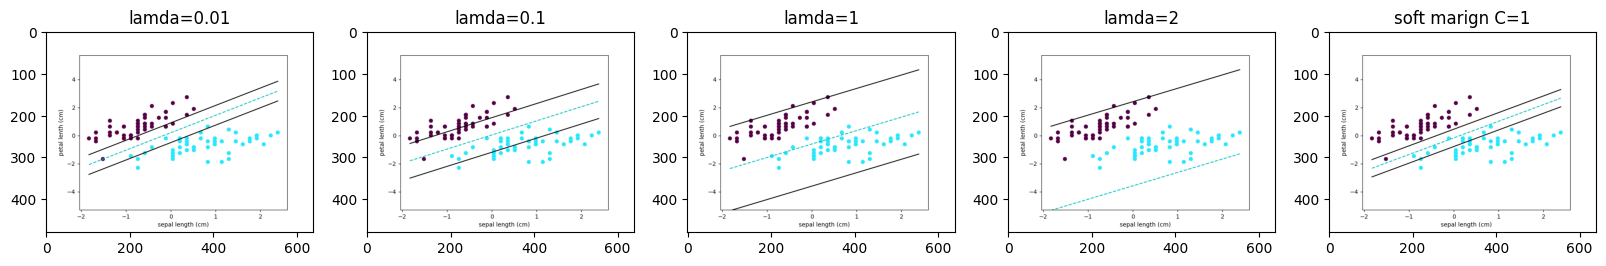

In [47]:
import cv2
fig = plt.figure(figsize=(20,16))
plt.subplot(151),plt.imshow(cv2.imread('./photo/SVM_result_lamda_0.01.png'), cmap='gray'),plt.title('lamda=0.01')
plt.subplot(152),plt.imshow(cv2.imread('./photo/SVM_result_lamda_0.1.png'), cmap='gray'),plt.title('lamda=0.1')
plt.subplot(153), plt.imshow(cv2.imread('./photo/SVM_result_lamda_1.png'), "gray"), plt.title("lamda=1")
plt.subplot(154),plt.imshow(cv2.imread('./photo/SVM_result_lamda_2.png'), cmap='gray'),plt.title('lamda=2')
plt.subplot(155),plt.imshow(cv2.imread('./photo/Soft_SVM_result.png'), cmap='gray'),plt.title('soft marign C=1')

$\text{SVM classification accuracy 1.0 \qquad} \text{SVM classification accuracy 0.99  \qquad}  \text{SVM classification accuracy 0.95   \qquad }  \text{SVM classification accuracy 0.45 \qquad} $

soft margin method fail to applying one vs rest algorithm seems because of datatype not fit